# Predict Storms 

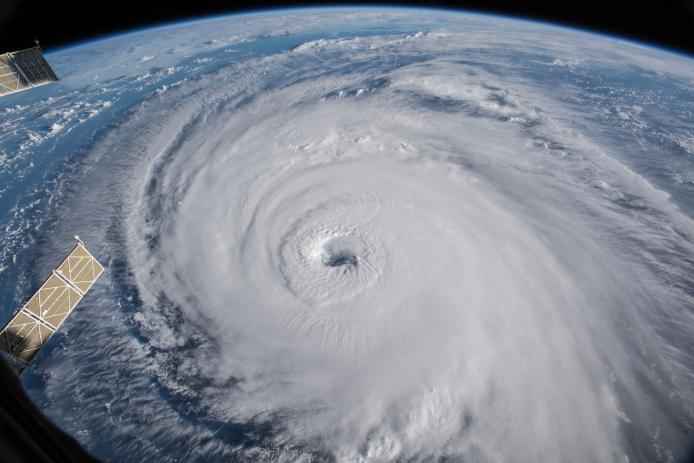

In [1]:
%matplotlib inline
from os.path import join, expanduser
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
from sklearn.preprocessing import StandardScaler
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, Flatten, LeakyReLU, Dropout
from keras.layers import SpatialDropout2D
from tensorflow.keras.optimizers import SGD, Adam
from keras import metrics
from keras.regularizers import l2
import keras.backend as K
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, roc_auc_score
from utils.utils import normalize_multivariate_data, plot_conv_layers_out
from models.keras_models import CNNStorm
from keras.models import save_model, load_model
import tensorflow as tf

In [2]:
path = "./data/track_data_ncar_ams_3km_csv_small/"
files = sorted(glob.glob(path+"/*.csv"))
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

In [3]:
df.columns

Index(['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
       'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC', 'Duration',
       'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
       'Storm_Motion_U', 'Storm_Motion_V', 'REFL_COM_mean', 'REFL_COM_max',
       'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10',
       'REFL_COM_percentile_25', 'REFL_COM_percentile_50',
       'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean',
       'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10',
       'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min',
       'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'T2_percentile_90', 'RVORT1_MAX-future_mean',
       'RVOR

In [4]:
df.head()

,Step_ID,Track_ID,Ensemble_Name,Ensemble_Member,Run_Date,Valid_Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,...,eccentricity,major_axis_length,minor_axis_length,orientation,Matched,Max_Hail_Size,Num_Matches,Shape,Location,Scale
0,d01_REFL_COM_20101024-0000_12_12_000_00,d01_REFL_COM_20101024-0000_12_12_000,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.43888,...,0.78628,4.27766,2.64302,-0.10555,0,0,0,0,0,0
1,d01_REFL_COM_20101024-0000_12_12_001_00,d01_REFL_COM_20101024-0000_12_12_001,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.06068,...,0.47108,7.07588,6.24158,-1.33266,0,0,0,0,0,0
2,d01_REFL_COM_20101024-0000_12_15_002_00,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.65033,...,0.87636,9.90123,4.76900,-0.10405,0,0,0,0,0,0
3,d01_REFL_COM_20101024-0000_12_15_002_01,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 13:00:00,13,13,2,-93.28486,...,0.97896,16.76704,3.42129,-0.71430,0,0,0,0,0,0
4,d01_REFL_COM_20101024-0000_12_15_002_02,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 14:00:00,14,14,3,-92.73067,...,0.94226,9.77854,3.27479,-0.91437,0,0,0,0,0,0


Text(0, 0.5, 'Temperature')

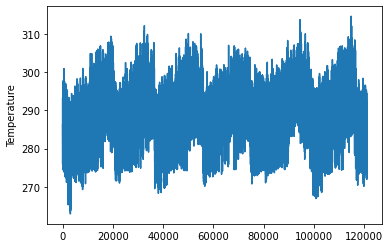

In [5]:
df['T2_mean'].plot()
plt.ylabel("Temperature")

Text(0.5, 1.0, 'Tornadic Storm Spatial Frequency')

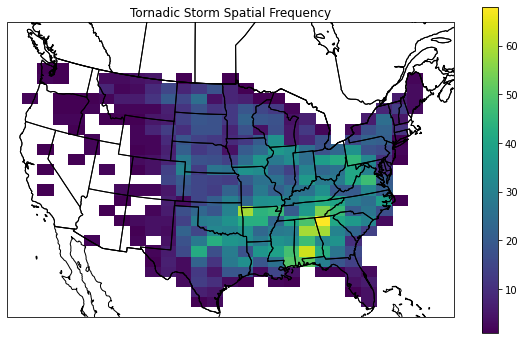

In [6]:
proj = ccrs.LambertConformal()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=proj)
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="None", edgecolor="k")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="k")
ax.add_feature(countries)
ax.add_feature(states)
tor_idx = df["RVORT1_MAX-future_max"] > 0.005
out_points = proj.transform_points(ccrs.PlateCarree(), 
                            df.loc[tor_idx, "Centroid_Lon"].values, df.loc[tor_idx, "Centroid_Lat"].values)
out = ax.hist2d(out_points[:, 0], out_points[:, 1], bins=(np.linspace(-2.5e6, 2.5e6, 30), 
                                                          np.linspace(-1.5e6, 1.8e6, 30)), cmin=1)
ax.set_extent([-2.5e6, 2.5e6, -1.5e6, 1.8e6], crs=proj)
plt.colorbar(out[-1])
plt.title("Tornadic Storm Spatial Frequency")

In [7]:
path = "./data/track_data_ncar_ams_3km_nc_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.nc"))


In [8]:
xf = xr.open_dataset(files[0])
xf

<xarray.Dataset>
Dimensions:            (col: 32, p: 1472, row: 32)
Coordinates:
  * p                  (p) int32 0 1 2 3 4 5 6 ... 1466 1467 1468 1469 1470 1471
  * row                (row) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * col                (col) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
Data variables: (12/20)
    lon                (p, row, col) float32 ...
    lat                (p, row, col) float32 ...
    i                  (p, row, col) int32 ...
    j                  (p, row, col) int32 ...
    x                  (p, row, col) float32 ...
    y                  (p, row, col) float32 ...
    ...                 ...
    REFL_COM_curr      (p, row, col) float32 ...
    U10_curr           (p, row, col) float32 ...
    V10_curr           (p, row, col) float32 ...
    T2_curr            (p, row, col) float32 ...
    RVORT1_MAX_future  (p, row, col) float32 ...
    HAIL_MAXK1_future  (p, row, col) float32 ...
Attributes:
    Conventions:      CF-1.6
    title:            NCARSTORM Storm Patches for run 20101024-0000 member d01
    object_variable:  REFL_COM

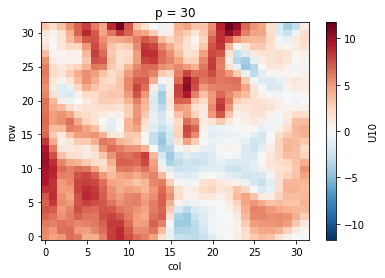

In [9]:
xf["U10_curr"].isel(p=30).plot()

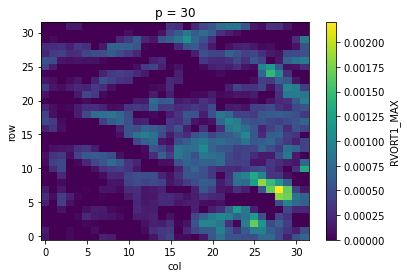

In [10]:
xf["RVORT1_MAX_future"].isel(p=30).plot()

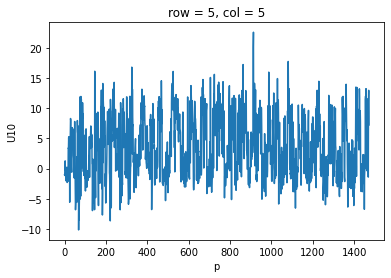

In [11]:
xf["U10_curr"].isel(col=5, row=5).plot()

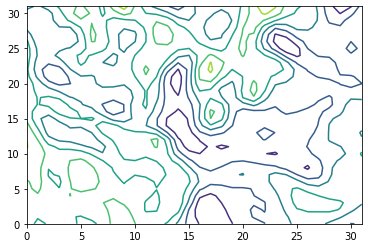

In [12]:
plt.contour(xf["U10_curr"][30,:,:])

### Ex1: 

Play with xarray plots and explore the dataset. 

## Prepare data for training 

In [13]:
features = ["REFL_COM_curr", "U10_curr", "V10_curr", "T2_curr"]
target = ["RVORT1_MAX_future"]
# vorticity threshold in s-1
out_threshold = 0.005

In [14]:
run_times = []
valid_times = []

inputs = []
output = []
# Loop through each storm file and extract the relevant variables
for storm_file in files:
    # Extract run time from the filename
    run_time = pd.Timestamp(storm_file.split("/")[-1].split("_")[-4])
    # If you want to ignore certain run_dates, encapsulate the remaining lines in an if statement
    ds = xr.open_dataset(storm_file)
    # Stack the variables in the order listed within a given file
    inputs.append(np.stack([ds[v].values for v in features], axis=-1))
    output.append(np.stack([ds[v].values for v in target], axis=-1))
    # Extract the valid times
    valid_times.append(ds["time"].values)
    # Extract the run times and match each run time with each patch
    run_times.append([run_time] * inputs[-1].shape[0])
    print(run_time)
    ds.close()
# Stack the  data into single arrays instead of lists of arrays
X = np.vstack(inputs)
y = np.vstack(output)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)

2010-10-24 00:00:00
2010-11-22 00:00:00
2011-02-01 00:00:00
2011-03-08 00:00:00
2011-03-26 00:00:00
2011-04-04 00:00:00
2011-04-14 00:00:00
2011-04-20 00:00:00
2011-04-25 00:00:00
2011-05-09 00:00:00
2011-05-22 00:00:00
2011-05-27 00:00:00
2011-06-05 00:00:00
2011-06-10 00:00:00
2011-06-15 00:00:00
2011-06-20 00:00:00
2011-06-25 00:00:00
2011-07-04 00:00:00
2011-07-12 00:00:00
2011-11-16 00:00:00
2012-02-18 00:00:00
2012-03-15 00:00:00
2012-03-23 00:00:00
2012-04-01 00:00:00
2012-04-09 00:00:00
2012-04-26 00:00:00
2012-05-03 00:00:00
2012-05-10 00:00:00
2012-05-29 00:00:00
2012-06-06 00:00:00
2012-06-22 00:00:00
2012-07-01 00:00:00
2012-07-06 00:00:00
2012-07-15 00:00:00
2012-12-25 00:00:00
2013-03-18 00:00:00
2013-03-31 00:00:00
2013-04-11 00:00:00
2013-04-29 00:00:00
2013-05-13 00:00:00
2013-05-19 00:00:00
2013-05-27 00:00:00
2013-06-02 00:00:00
2013-06-13 00:00:00
2013-06-19 00:00:00
2013-06-25 00:00:00
2013-07-01 00:00:00
2013-07-08 00:00:00
2013-07-15 00:00:00
2014-02-20 00:00:00


In [15]:
print(X.shape)
print(y.shape)

(121137, 32, 32, 4)
(121137, 32, 32, 1)


In [16]:
len(all_valid_times) == len(all_run_times)

True

In [17]:
train_test_date = pd.Timestamp("2015-01-01")
valid_dates = pd.DatetimeIndex(df["Valid_Date"])

In [18]:
X_train, scaling_values = normalize_multivariate_data(X[valid_dates < train_test_date])
X_test, _ = normalize_multivariate_data(X[valid_dates >= train_test_date], scaling_values=scaling_values)
print(scaling_values)
# Deallocate the lists of arrays to save memory
del inputs[:], output[:], run_times[:], valid_times[:]
del inputs, output, run_times, valid_times, X

         mean        std
0   22.437183  15.817961
1   -0.619780   4.428548
2    0.313597   5.116556
3  290.510223   7.642753


In [19]:
print(X_train.shape)
print(X_test.shape)

(76377, 32, 32, 4)
(44760, 32, 32, 4)


In [20]:
y_train = np.where(df.loc[valid_dates < train_test_date, 'RVORT1_MAX-future_max'] > out_threshold, 1, 0)
y_test = np.where(df.loc[valid_dates >= train_test_date, 'RVORT1_MAX-future_max'] > out_threshold, 1, 0)

### Ex3: 

What is the percentage of storm events in the training and in the test sets?

Channel:  REFL_COM_curr


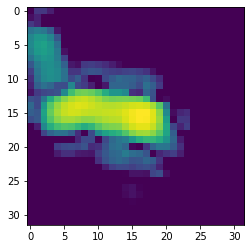

Channel:  U10_curr


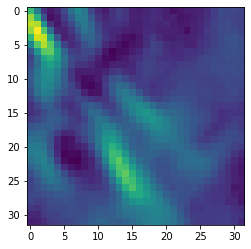

Channel:  V10_curr


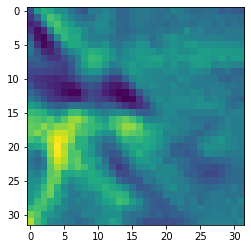

Channel:  T2_curr


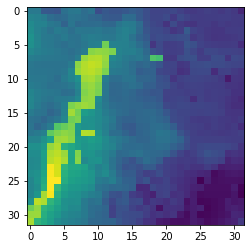

In [21]:
for i in range(len(features)):
    print("Channel: ", features[i])
    plt.imshow(X_train[0,:,:,i])
    plt.show()

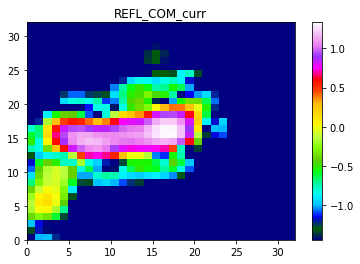

In [22]:
refl = plt.pcolormesh(X_train[0,:,:,0], cmap="gist_ncar")
plt.colorbar(refl)
plt.title(features[0])
plt.show()

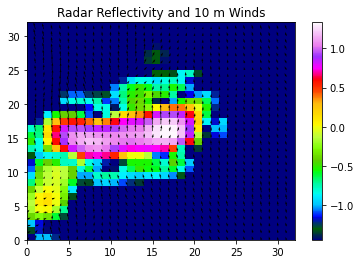

In [23]:
refl = plt.pcolormesh(X_train[0,:,:,0], cmap="gist_ncar")
plt.colorbar(refl)
plt.quiver(X_train[0,:,:,1], X_train[0,:,:,2])
plt.title("Radar Reflectivity and 10 m Winds", fontsize=12)
plt.show()

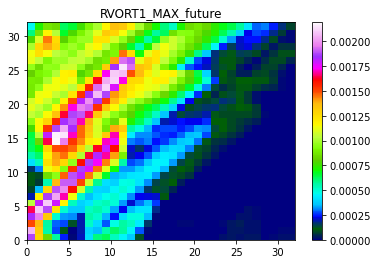

In [24]:
rot = plt.pcolormesh(y[0,:,:,0], cmap="gist_ncar")
plt.colorbar(rot)
plt.title(target[0])
plt.show()

### Ex3: 

Pick a storm event and play with matplotlib to make your favourite plot. Try to summarize and combine info from more than one variable in a single graph. 

In [41]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

conv_model = CNNStorm().initialize(X_train.shape, 4, 3, 'relu')
learning_rate = 0.001
opt = Adam(lr=learning_rate)
conv_model.compile(opt, "binary_crossentropy", metrics=METRICS)

In [42]:
conv_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 4)         0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 16, 16, 4)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 8)         296       
_________________________________________________________________
activation_13 (Activation)   (None, 16, 16, 8)         0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 8, 8, 8)           0   

In [43]:
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
conv_model.fit(X_train, y_train, batch_size=512, epochs=20, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[tb_callback])

Epoch 1/20
150/150 [==============================] - 30s 179ms/step - loss: 0.2974 - tp: 72.2053 - fp: 959.6093 - tn: 36166.0993 - fn: 1705.0927 - accuracy: 0.9016 - precision: 0.0700 - recall: 0.0903 - auc: 0.6503 - prc: 0.0663 - val_loss: 0.1768 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 42403.0000 - val_fn: 2357.0000 - val_accuracy: 0.9473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7983 - val_prc: 0.1358
Epoch 2/20
150/150 [==============================] - 22s 147ms/step - loss: 0.1561 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37146.5430 - fn: 1756.4636 - accuracy: 0.9555 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8007 - prc: 0.1263 - val_loss: 0.1593 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 42403.0000 - val_fn: 2357.0000 - val_accuracy: 0.9473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8601 - val_prc: 0.2743
Epoch 3/20
150/150 [==============================] - 22s 146ms/step - loss: 0.1405 - tp: 47.2914 -

Epoch 20/20
150/150 [==============================] - 27s 178ms/step - loss: 0.0985 - tp: 635.1722 - fp: 281.5828 - tn: 36853.0464 - fn: 1133.2053 - accuracy: 0.9635 - precision: 0.6943 - recall: 0.3573 - auc: 0.9507 - prc: 0.5595 - val_loss: 0.1075 - val_tp: 812.0000 - val_fp: 270.0000 - val_tn: 42133.0000 - val_fn: 1545.0000 - val_accuracy: 0.9595 - val_precision: 0.7505 - val_recall: 0.3445 - val_auc: 0.9483 - val_prc: 0.6129


In [44]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 6316), started 0:44:32 ago. (Use '!kill 6316' to kill it.)

### Ex4: 

Try to further simplify the architecture of the NN model and check whether similar scores can be obtained with a simpler model. The above CNN is overfitting to some extent, how can we correct for that? (Hint: dropout, early stopping, regularization). Play with the hyperparameters of the NN and see if you can improve the performance (e.g. activations, learning rate, weights initialization, etc.). 

### Ex5:

The dataset is highly unbalanced with only 5% of storm events. How is this affecting the performance of the model? What can be done to account for this and improve the scores? 

### Ex6: 

Define a F1 score metric and give it as an argument to model.compile(). Visualize the F1 curve per epochs in tensorboard. 

## Visualize learned representations 

In [49]:
conv_graph = K.function([conv_model.input], [conv_model.layers[3].output, 
                         conv_model.layers[6].output, 
                         conv_model.layers[9].output, 
                         conv_model.output])
conv_preds = conv_model.predict(X_train, batch_size=1024)


In [53]:
conv_outs = conv_graph([X_train[1:1+1]])

In [56]:
for i in conv_outs:
    print(i.shape)

(1, 16, 16, 4)
(1, 8, 8, 8)
(1, 1)
(1, 1)


/Users/Michele/mambaforge/envs/polito/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/Users/Michele/mambaforge/envs/polito/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


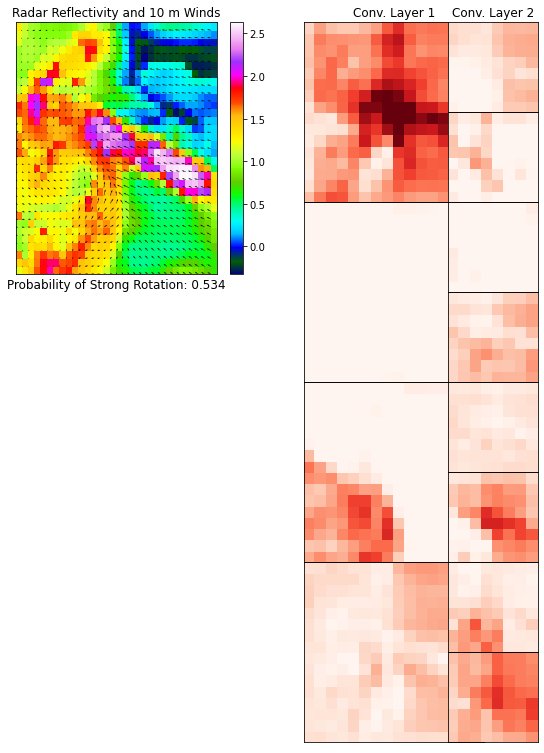

In [87]:
plot_conv_layers_out(44633,  X_test, conv_graph)

### Ex7:  

The activations of the convolutional layers are not easy to interpret. Explore a xAI method of your choice to further explore and explain the predictions of the model. (Hint: take a look at this package https://github.com/albermax/innvestigate )